In [1452]:
import numpy as np
import pandas as pd
import re

from sklearn.cluster import KMeans as KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.preprocessing import normalize

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

In [1453]:
import pdb2dataframe as p2d # self-made module to process data

In [1454]:
# dictionary to make it easy to obtain results by choosing which test parameters we used
parameters = {}
parameters['short_alpha_0.6'] = {'address': 'short_alpha/short_alpha.pdb/', 'eps': '0.06','sol_N': 2496, 'K': [20]}
parameters['short_alpha'] = {'address': 'short_alpha/short_alpha.pdb/', 'eps': '0.01','sol_N': 20000, 'K': [20]}
parameters['alpha'] = {'address': 'alpha/alpha.pdb/', 'eps': '0.01','sol_N': 10000, 'K': [10]}
parameters['alpha_mb128'] = {'address': 'alpha/alpha.pdb/', 'eps': '0.01, MB=128','sol_N': 10000, 'K': [25]}
parameters['2jmy'] = {'address': '2jmy/2jmy.pdb/', 'eps': '0.01','sol_N': 10000, 'K': [20]}

# K-Means Clustering of Different Protein Models

In this notebook, we attempt to cluster the different protein models produced by ibp-ng into clusters using K-Means. The first step is to compile the molecular data into a dataframe with each row representing all the locations of the atoms given by a single model.

In [1487]:
test_type = '' # insert test name here

this_test = parameters[test_type]


## Creating the Dataframe from the Data
The output of ibp-ng is produced in *.pdb file format. We must read these data files and convert the tables there-in into rows of a dataframe.

In [1456]:
# Address where output Atom Structure is Located
fileaddress = '../data/' + this_test['address']

In [1457]:
# initializes total number of models to be read
totalmodels = this_test['sol_N']

# number of digits in filenames
digits = 8


# creates a list of filenames in pdb folder with atom models
filenames = list( map(str,range(1,totalmodels+1)) )
for number in filenames:
    prepended_zeros = digits - len(number)
    filenames[int(number)-1] = prepended_zeros*'0'+number+'.pdb'

print(filenames[0:5])

['00000001.pdb', '00000002.pdb', '00000003.pdb', '00000004.pdb', '00000005.pdb']


In [1458]:
# Check to make sure file addresses are correct and file can be opened
file = open(fileaddress+filenames[0],'r')
filelines = file.readlines()
#print(filelines)
file.close()

### Steps to Create the Data Frame

In [1459]:
# find start and end / number of molecules
start,end = p2d.find_data_startend(filelines)
N_atoms = end-start
print(N_atoms)

78


In [1460]:
# numpy data matrix:
ncoordinates = N_atoms*3
#print(ncoordinates)
npdata = np.zeros([totalmodels,ncoordinates])

for i in np.arange(totalmodels):
    npdata[i]=p2d.atom_locations(fileaddress+filenames[i])

print(np.shape(npdata))

(10000, 234)


In [1461]:
# create data frame
atom_data_frame = pd.DataFrame(npdata)

### Creates a Dictionary of Headings for the Data Frame

In [1462]:
# gets just the data-section of the file
datatable = filelines[start:end]

# initializes column rename dictionary
column_dict = {}

for i in np.arange(N_atoms):
    
    # note that the column 1 is the atom number and column 2 is atom name
    atom_name = datatable[i].split()[1]+'-'+datatable[i].split()[2]
    
    # atom name and then coordinates x,y,z
    column_dict[3*i] = (atom_name,'x')
    column_dict[3*i+1] = (atom_name,'y')
    column_dict[3*i+2] = (atom_name,'z')

#print(column_dict)

In [1463]:
# renames columns in data frame with dictionary
atom_data_frame = atom_data_frame.rename(columns=column_dict)

First few rows of the data frame to demonstrate success.

In [1464]:
atom_data_frame.head()

0-N                  1-H1                  2-CA                   3-HA  \
       x       y      z      x       y      z      x       y      z       x   
0  8.502 -17.422  2.198  7.522 -17.422  2.198  8.998 -18.096  0.970  10.077   
1  8.504 -17.422  2.200  7.524 -17.422  2.200  9.000 -18.096  0.972  10.079   
2  8.441 -17.415  2.258  7.461 -17.415  2.258  8.937 -18.089  1.030  10.016   
3  8.441 -17.413  2.259  7.461 -17.413  2.259  8.937 -18.087  1.031  10.016   
4  8.440 -17.424  2.250  7.460 -17.424  2.250  8.936 -18.098  1.022  10.014   

   ...     74-C   75-O                 76-H2                  77-O2          \
   ...        z      x       y      z      x       y      z       x       y   
0  ...   -0.449 -8.807  20.150 -0.548  8.794 -16.486  2.198  -9.936  18.494   
1  ...   -0.447 -8.806  20.150 -0.546  8.795 -16.487  2.200 -10.122  18.518   
2  ...   -2.102 -6.152  18.692 -1.880  8.732 -16.479  2.258  -7.912  19.449   
3  ...   -2.101 -6.153  18.694 -1.879  8.732 -16.477  2.259  -7.884  19.201   
4  ...   -2.095 -7.397  18.436 -3.311  8.731 -16.488  2.250  -6.554  19.504   

          
       z  
0  0.356  
1  0.116  
2 -2.960  
3 -3.135  
4 -1.584  

[5 rows x 234 columns]

In [1465]:
atom_data_frame.describe()

0-N                                      1-H1                \
                  x             y             z             x             y   
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.000000   
mean       8.352078    -17.281978      1.901945      7.372078    -17.281978   
std        0.264953      0.124132      0.255782      0.264953      0.124132   
min        7.893000    -17.550000      1.448000      6.913000    -17.550000   
25%        8.185000    -17.372250      1.723000      7.205000    -17.372250   
50%        8.350000    -17.287000      1.883000      7.370000    -17.287000   
75%        8.507000    -17.198000      2.071000      7.527000    -17.198000   
max        8.843000    -16.951000      2.381000      7.863000    -16.951000   

                             2-CA                                      3-HA  \
                  z             x             y             z             x   
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.000000   
mean       1.901945      8.848114    -17.956009      0.674013      9.926951   
std        0.255782      0.264955      0.124142      0.255791      0.264945   
min        1.448000      8.389000    -18.224000      0.221000      9.467000   
25%        1.723000      8.681750    -18.046250      0.495750      9.760000   
50%        1.883000      8.847000    -17.961000      0.655000      9.925000   
75%        2.071000      9.003000    -17.872000      0.844000     10.082000   
max        2.381000      9.339000    -17.625000      1.153000     10.418000   

           ...              74-C          75-O                              \
           ...                 z             x             y             z   
count      ...       10000.00000  10000.000000  10000.000000  10000.000000   
mean       ...           1.68720     -6.205133     16.960624      1.670080   
std        ...           2.86002      3.102924      2.032053      3.017611   
min        ...          -3.74500    -12.566000     11.613000     -4.686000   
25%        ...          -0.61000     -8.812000     15.461000     -0.884750   
50%        ...           1.88800     -6.066000     17.121000      1.842000   
75%        ...           4.21800     -3.528000     18.473000      4.297500   
max        ...           6.61000     -0.191000     21.429000      7.413000   

              76-H2                                     77-O2                \
                  x             y             z             x             y   
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.000000   
mean       8.643511    -16.346307      1.901945     -6.175958     17.170363   
std        0.264904      0.124113      0.255782      3.378454      1.990508   
min        8.184000    -16.614000      1.448000    -12.720000     11.839000   
25%        8.477000    -16.436250      1.723000     -8.838000     15.717000   
50%        8.642000    -16.351000      1.883000     -6.025000     17.309000   
75%        8.798000    -16.263000      2.071000     -3.314500     18.724000   
max        9.134000    -16.015000      2.381000     -0.003000     21.583000   

                     
                  z  
count  10000.000000  
mean       1.744693  
std        3.264091  
min       -4.876000  
25%       -0.950000  
50%        1.856000  
75%        4.586000  
max        7.727000  

[8 rows x 234 columns]

In [1466]:
average_std = atom_data_frame.describe().mean(axis=1)
var_std = atom_data_frame.describe().std(axis=1)

print(average_std)
print()
print(var_std)

count    10000.000000
mean        -0.028682
std          0.427823
min         -0.854744
25%         -0.344530
50%         -0.020705
75%          0.288075
max          0.784808
dtype: float64

count    0.000000
mean     7.241443
std      0.620906
min      7.179773
25%      7.225538
50%      7.243606
75%      7.297413
max      7.442334
dtype: float64


## K-Means Clustering of Data
Here we try to compute a K-Means clustering of the data using the above dataframe. We use the scikit-learn implementation to do so.

In [1467]:
# number of clusters to be created
K = this_test['K'][0]

In [1468]:
# Computes KMeans
cluster_result = KMeans(K).fit(atom_data_frame)

# get the centers of the clustering using:
centers = cluster_result.cluster_centers_

# changes centers to data frame:
clustered_models_data = pd.DataFrame(centers)
clustered_models_data = clustered_models_data.rename(columns=column_dict)

In [1469]:
clustered_models_data


0-N                           1-H1                           2-CA  \
           x          y         z         x          y         z         x   
0   8.339520 -17.248235  1.516439  7.359520 -17.248235  1.516439  8.835622   
1   8.462849 -17.476616  2.200630  7.482849 -17.476616  2.200630  8.958930   
2   7.973268 -17.257652  2.150268  6.993268 -17.257652  2.150268  8.469278   
3   8.785624 -17.183118  1.763252  7.805624 -17.183118  1.763252  9.281630   
4   8.273161 -17.285815  1.889806  7.293161 -17.285815  1.889806  8.769177   
5   8.708021 -17.277720  1.700000  7.728021 -17.277720  1.700000  9.204043   
6   8.456814 -17.364819  2.336300  7.476814 -17.364819  2.336300  8.952881   
7   8.202312 -17.186304  1.571589  7.222313 -17.186304  1.571589  8.698384   
8   7.996705 -17.344256  1.954237  7.016705 -17.344256  1.954237  8.492731   
9   8.765485 -17.362791  1.876485  7.785485 -17.362791  1.876485  9.261575   
10  8.148883 -17.071944  1.612648  7.168883 -17.071944  1.612648  8.644914   
11  8.271122 -17.359600  1.965122  7.291122 -17.359600  1.965122  8.767167   
12  8.399625 -17.360950  1.912675  7.419625 -17.360950  1.912675  8.895650   
13  7.925032 -17.220960  1.935397  6.945032 -17.220960  1.935397  8.421063   
14  8.361195 -17.302627  1.825712  7.381195 -17.302627  1.825712  8.857220   
15  8.351957 -17.448526  2.299362  7.371957 -17.448526  2.299362  8.848009   
16  8.616487 -17.356598  2.297103  7.636487 -17.356598  2.297103  9.112518   
17  8.325771 -17.095299  1.506083  7.345771 -17.095299  1.506083  8.821799   
18  8.486975 -17.256550  1.820525  7.506975 -17.256550  1.820525  8.982975   
19  8.427839 -17.343125  1.995563  7.447839 -17.343125  1.995563  8.923839   

                              3-HA    ...         74-C       75-O             \
            y         z          x    ...            z          x          y   
0  -17.922235  0.288541   9.914378    ...     5.567684  -5.802776  17.712765   
1  -18.150651  0.972680  10.037694    ...    -0.973130  -7.914585  19.513891   
2  -17.931682  0.922348   9.548162    ...    -0.959929  -2.322657  16.557061   
3  -17.857155  0.535270  10.360476    ...     2.643206 -10.989882  15.230924   
4  -17.959863  0.661919   9.848048    ...     2.718968  -3.998250  16.316984   
5  -17.951720  0.472007  10.282947    ...     4.381794  -9.410674  17.155216   
6  -18.038886  1.108378  10.031572    ...    -3.177036  -7.697586  17.213208   
7  -17.860339  0.343652   9.777170    ...     4.924661  -3.792795  16.365393   
8  -18.018263  0.726295   9.571647    ...     0.726782  -2.928724  18.589814   
9  -18.036877  0.648567  10.340347    ...     2.008056 -10.513534  18.280854   
10 -17.745944  0.384741   9.723802    ...     5.148228  -4.102815  14.072191   
11 -18.033633  0.737144   9.846011    ...     0.532333  -3.798811  18.184122   
12 -18.035000  0.684713   9.974538    ...     0.881900  -7.791388  18.515663   
13 -17.895008  0.707468   9.499881    ...     1.635476  -1.372770  15.378317   
14 -17.976644  0.597763   9.936059    ...     3.844695  -7.415356  17.011678   
15 -18.122621  1.071397   9.926724    ...    -2.390052  -5.424733  18.882569   
16 -18.030607  1.069308  10.191393    ...    -2.781960  -9.127504  17.211330   
17 -17.769312  0.278160   9.900625    ...     5.994104  -6.393562  14.481465   
18 -17.930550  0.592575  10.061813    ...     1.990038  -9.224788  16.808937   
19 -18.017152  0.767643  10.002768    ...    -0.752946  -6.723813  18.202920   

                 76-H2                           77-O2                       
           z         x          y         z          x          y         z  
0   5.602980  8.631010 -16.312694  1.516439  -4.937235  17.606551  5.852276  
1  -0.672222  8.754335 -16.540852  2.200630  -8.493813  19.643046 -1.197215  
2  -1.281197  8.264783 -16.321975  2.150268  -1.596076  16.298682 -1.107313  
3   2.742533  9.076961 -16.247424  1.763252 -11.615476  15.713500  2.555706  
4   2.716984  8.564548 -16.350113  1.889806  -3.636427  16.6372

### Understanding Clusters
Next we try and visualize the differences between these clusters by measuring the variation between the average location of molecules overall and the location of the cluster centers.

In [1470]:
# get a list of atom names
atom_names = list(name[0] for name in atom_data_frame.columns.values[::3])
print(atom_names)

['0-N', '1-H1', '2-CA', '3-HA', '4-C', '5-N', '6-H1', '7-CA', '8-HA', '9-C', '10-N', '11-H1', '12-CA', '13-HA', '14-C', '15-N', '16-H1', '17-CA', '18-HA', '19-C', '20-N', '21-H1', '22-CA', '23-HA', '24-C', '25-N', '26-H1', '27-CA', '28-HA', '29-C', '30-N', '31-H1', '32-CA', '33-HA', '34-C', '35-N', '36-H1', '37-CA', '38-HA', '39-C', '40-N', '41-H1', '42-CA', '43-HA', '44-C', '45-N', '46-H1', '47-CA', '48-HA', '49-C', '50-N', '51-H1', '52-CA', '53-HA', '54-C', '55-N', '56-H1', '57-CA', '58-HA', '59-C', '60-N', '61-H1', '62-CA', '63-HA', '64-C', '65-N', '66-H1', '67-CA', '68-HA', '69-C', '70-N', '71-H1', '72-CA', '73-HA', '74-C', '75-O', '76-H2', '77-O2']


In [1471]:
# find average locations of whole dataset
mean_loc = atom_data_frame.mean(axis=0)

# create data frame for distances
distance = pd.DataFrame(np.zeros([clustered_models_data.shape[0],len(atom_names)]))
new_dict = {i:name for i,name in enumerate(atom_names)}  # to rename the columns
distance = distance.rename(columns=new_dict)

# calculate the distances of each cluster center from average center
for name in atom_names:
     distance[name] = np.sqrt(((clustered_models_data[name]-mean_loc[name])**2).sum(axis=1))

distance


,0-N,1-H1,2-CA,3-HA,4-C,5-N,6-H1,7-CA,8-HA,9-C,...,68-HA,69-C,70-N,71-H1,72-CA,73-HA,74-C,75-O,76-H2,77-O2
0,0.387183,0.387183,0.387151,0.387206,0.387184,0.387128,0.387181,0.387122,0.387186,0.387153,...,0.554490,1.851781,2.464800,2.382797,3.577482,3.929107,3.959077,4.024340,0.387170,4.312415
1,0.373320,0.373320,0.373320,0.373345,0.373340,0.373346,0.373324,0.373296,0.373323,0.373347,...,0.729648,1.921783,2.238400,1.797252,3.527152,3.886483,3.976146,3.863648,0.373287,4.487921
2,0.453600,0.453600,0.453629,0.453603,0.453563,0.453578,0.453611,0.453499,0.453597,0.453623,...,0.145529,2.009840,2.785914,2.536428,4.144162,4.380868,4.881077,4.893518,0.453532,5.465262
3,0.465802,0.465802,0.465788,0.465795,0.465803,0.465796,0.465709,0.465684,0.465823,0.465789,...,0.307890,2.073919,2.869104,2.560355,4.267630,4.475945,5.104041,5.199600,0.465717,5.689336
4,0.079937,0.079937,0.079951,0.079916,0.080025,0.080004,0.079966,0.080017,0.079960,0.079951,...,1.935717,0.403800,0.625207,0.258600,1.843363,2.074849,2.468415,2.525987,0.079981,2.914990
5,0.409262,0.409262,0.409280,0.409311,0.409168,0.409263,0.409298,0.409321,0.409363,0.409325,...,0.627125,1.979636,2.465452,2.138349,3.828422,4.152149,4.430441,4.346997,0.409281,5.029800
6,0.454419,0.454419,0.454442,0.454423,0.454458,0.454399,0.454379,0.454375,0.454376,0.454493,...,0.260351,2.012686,2.837973,2.721270,4.170012,4.325851,5.025668,5.041535,0.454410,5.721065
7,0.375124,0.375124,0.375114,0.375209,0.375164,0.375022,0.375107,0.375053,0.375123,0.375126,...,0.933162,1.888878,2.239595,1.867007,3.579489,3.912756,4.090958,3.969232,0.375145,4.632376
8,0.364558,0.364558,0.364563,0.364484,0.364518,0.364571,0.364469,0.364501,0.364504,0.364519,...,0.825206,1.853162,2.212105,1.768754,3.428119,3.815971,3.779631,3.705863,0.364482,4.209247
9,0.422001,0.422001,0.422063,0.422003,0.422097,0.422067,0.422055,0.422059,0.421978,0.421991,...,0.394336,1.907374,2.660219,2.546171,3.872720,4.160404,4.379711,4.507172,0.422047,4.702277


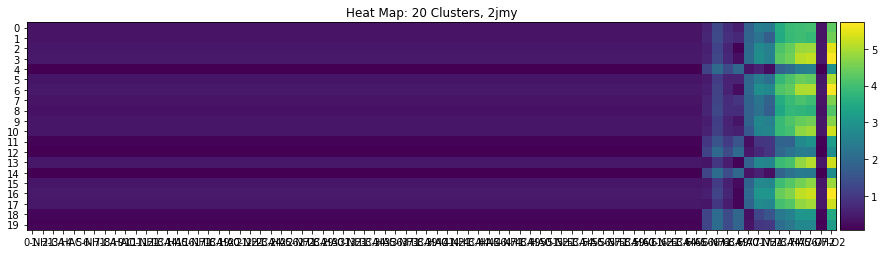

In [1472]:
# heat map plot of the the distances of each atom from the average location of the atom
fig_heat = plt.figure(figsize=(15,12))
ax = plt.gca()
plt.yticks(np.arange(0.5, len(distance.index), 1)-0.5, distance.index)
plt.xticks(np.arange(0.5, len(distance.columns), 1)-0.5, distance.columns)
plt.imshow(distance)

titlestr = 'Heat Map: '+str(K)+ ' Clusters, '+test_type
plt.title(titlestr)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.05)
plt.colorbar(cax = cax)



The above plot gives a sense of the distribution of how each models atom location varies from the overall average positions of each of the atoms.

Next we look at how many of the models lie in each of the 20 clusters. In other words, are most of the solutions drawn from similar potential models?

In [1473]:
# creates a data frame which assigns each model to one of the clusters.
which_cluster = pd.DataFrame({'assigned cluster': cluster_result.predict(atom_data_frame)})
which_cluster['assigned cluster'] = which_cluster['assigned cluster'].astype('category')
which_cluster.head()

,assigned cluster
0,1
1,1
2,1
3,1
4,1


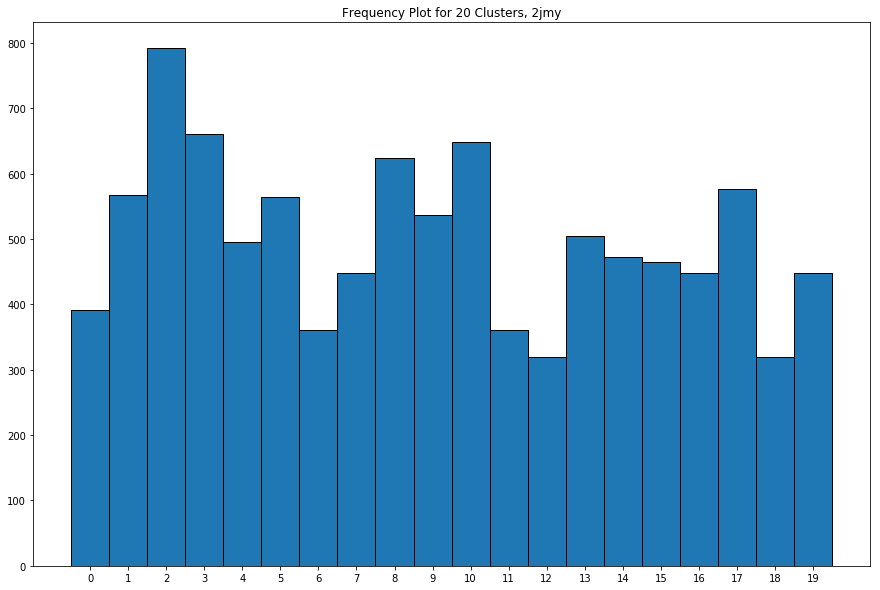

In [1474]:
fig_freq = plt.figure(figsize=(15,10))
plt.hist(which_cluster['assigned cluster'],bins=(np.arange(K+1)-0.5),edgecolor='black')
plt.xticks(np.arange(K))

titlestr = 'Frequency Plot for '+str(K)+' Clusters, '+test_type
plt.title(titlestr)
plt.show()

Next we find a representative of each cluster by selecting the model (data point) which was closest to the centroid for each cluster.

In [1475]:
# finds the minimum distance between the center and each model for every center
closest, _ = pairwise_distances_argmin_min(centers, atom_data_frame)

# creates list of filenames for reference
digits = 8 # number of digits in filenames
closest_names = []
for i,number in enumerate(closest):
    prepended_zeros = digits - len(str(number))
    closest_names.append(prepended_zeros*'0'+str(number)+'.pdb')

# creates table of the names
closest_table = pd.DataFrame({'Closest Model to Centroid':closest_names})
closest_table

,Closest Model to Centroid
0,00003433.pdb
1,00000843.pdb
2,00000651.pdb
3,00003275.pdb
4,00007851.pdb
5,00007690.pdb
6,00008171.pdb
7,00003999.pdb
8,00005963.pdb
9,00008555.pdb


## Principal Component Analysis
Here I perform a principle component analysis to get a sense of how the different modeled proteins differ in their first two principle components. In other words, to get a visual 2D sense of the distribution how different each of the models are from one another.

In [1476]:
# Create a PCA Data Frame with only the first two components
pca_data = PCA(n_components=2).fit(atom_data_frame)
pca_data_frame = pd.DataFrame(pca_data.transform(atom_data_frame))
pca_data_frame.columns = ['PC1','PC2']
pca_data_frame.head()


,PC1,PC2
0,5.519049,8.084592
1,5.601432,8.191641
2,8.658388,5.915373
3,8.700418,5.900384
4,8.397787,5.753209


Text(0.5,1,'PCA Plot: First two components, 2jmy')

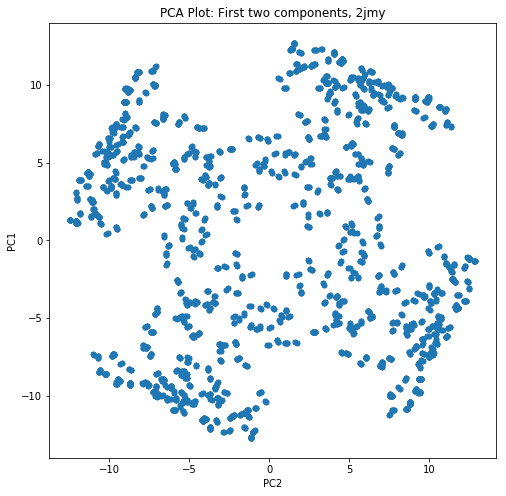

In [1477]:
pca_only, ax = plt.subplots(figsize=(8,8))
pca_data_frame.plot(kind='scatter', x='PC2', y='PC1', ax=ax, figsize=(8,8))

titlestr = "PCA Plot: First two components, "+test_type
plt.title(titlestr)

From the plot above, it is clear that there a bunch of models which are distinctly different than the others. We were interested in which models these were.

The following analysis searched for the rows who had a PC1 greater than 10.

In [1478]:
# Identifies the elements
pca_data_frame.loc[pca_data_frame['PC1']>5]

,PC1,PC2
0,5.519049,8.084592
1,5.601432,8.191641
2,8.658388,5.915373
3,8.700418,5.900384
4,8.397787,5.753209
5,8.419865,5.871947
6,6.877228,8.242931
7,6.755870,8.306329
8,7.310625,7.804073
9,7.427902,7.846483


It looked like all of these were in the first model iterations.

Indeed, all of these models were in this first group:

In [1479]:
try:
    all(pca_data_frame.loc[pca_data_frame['PC1']>5].index == np.arange(3600)+400)
except:
    print('Check the range of indices again and re-run cell.')

Check the range of indices again and re-run cell.


### Overlay the Clustering with the PCA Analysis
We overlay the KMeans clustering on top of the PCA Analysis to see how the cluster's centroids appear in the 2D PCA space.


In [1480]:
# Transforms the clustered centroids using the Princ. Component weights from the full data set
clustered_pc = pd.DataFrame(pca_data.transform(centers))
clustered_pc.columns = ['PC1','PC2']
print(clustered_pc.shape)
clustered_pc

(20, 2)


,PC1,PC2
0,-8.892352,-3.067041
1,7.287553,6.215615
2,7.973543,-8.824468
3,-6.246974,10.459033
4,-0.812968,-4.909346
5,-7.885390,7.519339
6,10.991028,4.901814
7,-7.136080,-7.034866
8,4.841320,-7.693114
9,-2.530677,10.601074


In [1481]:
# combines two data frames for comparison
pca_data_frame['Key'] = 'a full data set'
clustered_pc['Key'] = 'clustered centroids'

compare = pd.concat([clustered_pc,pca_data_frame],keys=['clustered centroids','a full data set'])
#compare

                        PC1       PC2              Key
a full data set 0  5.519049  8.084592  a full data set
                1  5.601432  8.191641  a full data set
                2  8.658388  5.915373  a full data set
                3  8.700418  5.900384  a full data set
                4  8.397787  5.753209  a full data set
a full data set
                            PC1        PC2                  Key
clustered centroids 0 -8.892352  -3.067041  clustered centroids
                    1  7.287553   6.215615  clustered centroids
                    2  7.973543  -8.824468  clustered centroids
                    3 -6.246974  10.459033  clustered centroids
                    4 -0.812968  -4.909346  clustered centroids
clustered centroids


Text(0.5,1,'Clustered Centroids PCA, 2jmy')

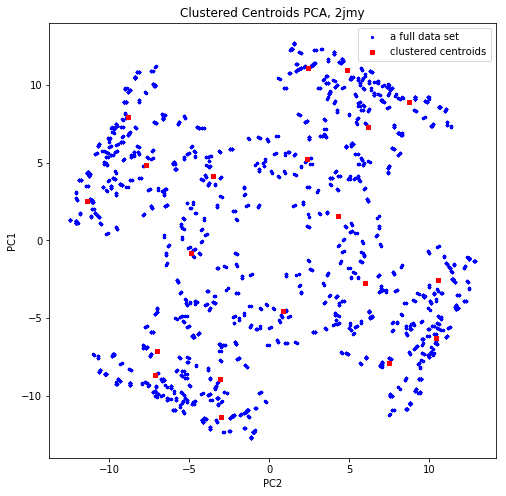

In [1482]:
pca_clust_plot, ax = plt.subplots(figsize=(8,6))

for label, df in compare.groupby('Key'):
    print(df.head())
    print(label)
    if (label=='clustered centroids'):
        color = 'r'
        m = 's'
    else: 
        color = 'b'
        m = '.'
    df.plot(kind='scatter', x='PC2', y='PC1', figsize=(8,8),ax=ax,c=color,label=label,marker=m)
plt.legend()

titlestr = 'Clustered Centroids PCA, '+test_type
plt.title(titlestr)

## Save all Figures:
Saves all previous figures and lists table info.

In [1483]:
# table info for descriptive statistics
print(average_std)
print()
print(var_std)

# table info for example atom
atom_data_frame.describe()

count    10000.000000
mean        -0.028682
std          0.427823
min         -0.854744
25%         -0.344530
50%         -0.020705
75%          0.288075
max          0.784808
dtype: float64

count    0.000000
mean     7.241443
std      0.620906
min      7.179773
25%      7.225538
50%      7.243606
75%      7.297413
max      7.442334
dtype: float64


0-N                                      1-H1                \
                  x             y             z             x             y   
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.000000   
mean       8.352078    -17.281978      1.901945      7.372078    -17.281978   
std        0.264953      0.124132      0.255782      0.264953      0.124132   
min        7.893000    -17.550000      1.448000      6.913000    -17.550000   
25%        8.185000    -17.372250      1.723000      7.205000    -17.372250   
50%        8.350000    -17.287000      1.883000      7.370000    -17.287000   
75%        8.507000    -17.198000      2.071000      7.527000    -17.198000   
max        8.843000    -16.951000      2.381000      7.863000    -16.951000   

                             2-CA                                      3-HA  \
                  z             x             y             z             x   
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.000000   
mean       1.901945      8.848114    -17.956009      0.674013      9.926951   
std        0.255782      0.264955      0.124142      0.255791      0.264945   
min        1.448000      8.389000    -18.224000      0.221000      9.467000   
25%        1.723000      8.681750    -18.046250      0.495750      9.760000   
50%        1.883000      8.847000    -17.961000      0.655000      9.925000   
75%        2.071000      9.003000    -17.872000      0.844000     10.082000   
max        2.381000      9.339000    -17.625000      1.153000     10.418000   

           ...              74-C          75-O                              \
           ...                 z             x             y             z   
count      ...       10000.00000  10000.000000  10000.000000  10000.000000   
mean       ...           1.68720     -6.205133     16.960624      1.670080   
std        ...           2.86002      3.102924      2.032053      3.017611   
min        ...          -3.74500    -12.566000     11.613000     -4.686000   
25%        ...          -0.61000     -8.812000     15.461000     -0.884750   
50%        ...           1.88800     -6.066000     17.121000      1.842000   
75%        ...           4.21800     -3.528000     18.473000      4.297500   
max        ...           6.61000     -0.191000     21.429000      7.413000   

              76-H2                                     77-O2                \
                  x             y             z             x             y   
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.000000   
mean       8.643511    -16.346307      1.901945     -6.175958     17.170363   
std        0.264904      0.124113      0.255782      3.378454      1.990508   
min        8.184000    -16.614000      1.448000    -12.720000     11.839000   
25%        8.477000    -16.436250      1.723000     -8.838000     15.717000   
50%        8.642000    -16.351000      1.883000     -6.025000     17.309000   
75%        8.798000    -16.263000      2.071000     -3.314500     18.724000   
max        9.134000    -16.015000      2.381000     -0.003000     21.583000   

                     
                  z  
count  10000.000000  
mean       1.744693  
std        3.264091  
min       -4.876000  
25%       -0.950000  
50%        1.856000  
75%        4.586000  
max        7.727000  

[8 rows x 234 columns]

In [1484]:
# best representative table
closest_table

,Closest Model to Centroid
0,00003433.pdb
1,00000843.pdb
2,00000651.pdb
3,00003275.pdb
4,00007851.pdb
5,00007690.pdb
6,00008171.pdb
7,00003999.pdb
8,00005963.pdb
9,00008555.pdb


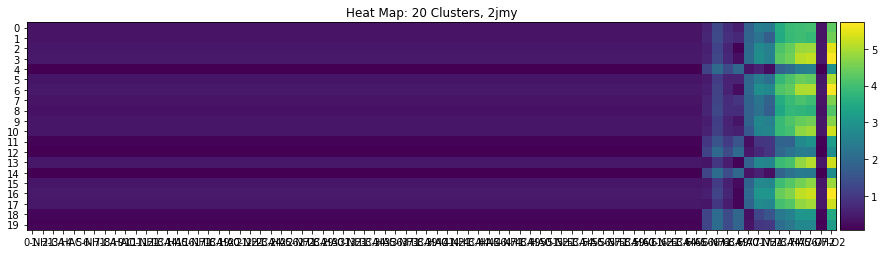

In [1485]:
# dictionary of key figures
key_figures = {'heatmap': fig_heat, 'cluster_freq': fig_freq, 'PCA': pca_only, 'PCA_with_clusters': pca_clust_plot}

key_figures['heatmap']

In [1486]:
# saves key figures to folder
savefileaddress = 'figures/'

for key in list(key_figures.keys()):
    savefilename = test_type + '-' + key +'.png'
    key_figures[key].savefig(savefileaddress+savefilename)
    print(savefilename+' has been saved!?!')
    
print()

2jmy-heatmap.png has been saved!?!
2jmy-cluster_freq.png has been saved!?!
2jmy-PCA.png has been saved!?!
2jmy-PCA_with_clusters.png has been saved!?!

